In [1]:
#performing grid scan from A/gamma parameter space to n_T/r parameter space

import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [4]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

k_eq = 0.073 * Omega_M * h_0**2 #from papers

In [27]:
#plot A/gamma posterior approximation, from Vagnozzi paper
mu15 = np.array([-14.2, 3.2])
sigma15 = np.array([[0.127, -0.045], [-0.045, 0.021]])
tst = scipy.stats.multivariate_normal(mu15, sigma15)
print(tst.pdf())

TypeError: multivariate_normal_frozen.pdf() missing 1 required positional argument: 'x'

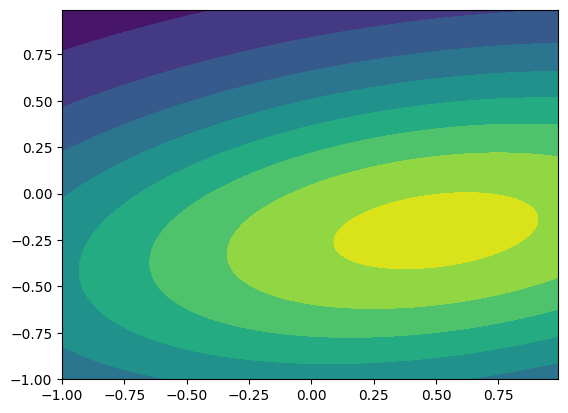

In [29]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = scipy.stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

In [8]:
from   matplotlib import cm
from   mpl_toolkits.mplot3d import Axes3D

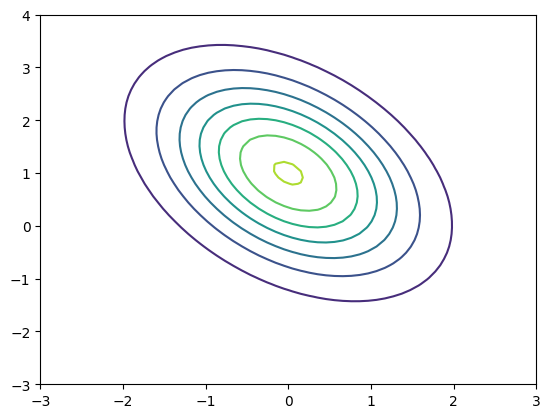

In [10]:
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
F = scipy.stats.multivariate_normal(mu, Sigma)
Z = F.pdf(pos)


# # Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.add_subplot()
# ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=cm.viridis)

cset = ax.contour(X, Y, Z, cmap=cm.viridis)

# # # Adjust the limits, ticks and view angle
# # ax.set_zlim(-0.15,0.2)
# # ax.set_zticks(np.linspace(0,0.2,5))
# # ax.view_init(27, -21)

plt.show()